## Import

In [1]:
import torch 
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import os
from torch import optim
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_sequence
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from nmt.model import EncoderLSTM, DecoderLSTM, DotAttenDecoderLSTM
from nmt.train import train, trainIters
from nmt.infer import infer
from nmt.eval import eval
from nmt.utils import BatchGenerator

## Data Setup

In [3]:
MAX_LENGTH = 25

In [4]:
# set data path
data_dir = os.path.join('datasets', 'nmt_data_vi')
train_source = 'train.vi'
train_target = 'train.en'
train_source_dir = os.path.join(data_dir, train_source)
train_target_dir = os.path.join(data_dir, train_target)

test_source = 'tst2012.vi'
test_target = 'tst2012.en'
test_source_dir = os.path.join(data_dir, test_source)
test_target_dir = os.path.join(data_dir, test_target)

vocab_source = 'vocab.vi'
vocab_target = 'vocab.en'
vocab_source_dir = os.path.join(data_dir, vocab_source)
vocab_target_dir = os.path.join(data_dir, vocab_target)

In [5]:
# load training sets
with open(train_source_dir) as f_source:
    sentences_source = f_source.readlines()
with open(train_target_dir) as f_target:
    sentences_target = f_target.readlines()

# check the total number of sentencs in training sets    
print("Total number of sentences in source training set: {}".format(len(sentences_source)))
print("Total number of sentences in target training set: {}".format(len(sentences_target)))

# load testing sets
with open(test_source_dir) as f_source:
    test_source = f_source.readlines()
with open(test_target_dir) as f_target:
    test_target = f_target.readlines()

# check the total number of sentencs in training sets    
print("Total number of sentences in source testing set: {}".format(len(test_source)))
print("Total number of sentences in target testing set: {}".format(len(test_target)))

Total number of sentences in source training set: 133317
Total number of sentences in target training set: 133317
Total number of sentences in source testing set: 1553
Total number of sentences in target testing set: 1553


In [6]:
# check the longest sentence after sentence truncation
max = 0
for s in sentences_source:
    if len(s) > max:
        max = len(s)
        max_s = s
print("Number of words in the longest sentence in sentences_source: {}".format(max))
print("The longest sentence: \n{}".format(max_s))

Number of words in the longest sentence in sentences_source: 3199
The longest sentence: 
Thula Mama , Thula Mama , Thula Mama , Thula Mama . Trong kí ức tuổi thơ con , qua những giọt lệ nhoè mắt bà , con thấy chân lý trong nụ cười của bà , con thấy chân lý trong nụ cười của bà , xuyên thấu màn đêm u tối trong sự vô tri của con . Ôi , có một người bà đang nằm nghỉ bà ốm đau và trái tim bà rơi lệ . Băn khoăn , băn khoăn , băn khoăn , băn khoăn liệu thế giới này đang đi về đâu . Lẽ nào chuyện trẻ nhỏ phải tự xoay xở lấy là đúng ? Không , không , không , không , không , không . Lẽ nào phiền muộn dồn hết lên mái đầu người phụ nữ già là đúng ? Những người vô danh bất hạnh . Thula Mama Mama , Thula Mama . Thula Mama Mama . Thula Mama , Thula Mama , Thula Mama Mama , Thula Mama . Ngày mai sẽ tốt đẹp hơn . Ngày mai trèo đèo lội suối sẽ dễ hơn , bà ơi . Thula Mama , Thula Mama . Tôi có nên tan vào bài hát này như người đàn ông hát nhạc blues hay một người hát rong . Và rồi từ rất xa , không phải

In [7]:
# Truncate sentences by maximum length
sentences_source = list(map(lambda src:src.split()[:MAX_LENGTH], sentences_source))
sentences_target = list(map(lambda src:src.split()[:MAX_LENGTH], sentences_target))
test_source = list(map(lambda src:src.split()[:MAX_LENGTH], test_source))
test_target = list(map(lambda src:src.split()[:MAX_LENGTH], test_target))

In [8]:
# Delete empty sentences in source and target
i = 0
while i < len(sentences_source):
    if sentences_source[i]==[] or sentences_target[i]==[]:
        del sentences_source[i]
        del sentences_target[i]
        i -= 1
    i += 1
print(len(sentences_source))
print(len(sentences_target))

i = 0
while i < len(sentences_source):
    if sentences_source[i]==[] or sentences_target[i]==[]:
        del test_source[i]
        del test_target[i]
        i -= 1
    i += 1
print(len(test_source))
print(len(test_target))

133166
133166
1553
1553


In [9]:
# load vocabularies

# build index2word
with open(vocab_source_dir) as f_vocab_source:
    #index2word_source = f_vocab_source.readlines()
    index2word_source = [line.rstrip() for line in f_vocab_source]
with open(vocab_target_dir) as f_vocab_target:
    #index2word_target = f_vocab_target.readlines()
    index2word_target = [line.rstrip() for line in f_vocab_target]

# build word2index
word2index_source = {}
for idx, word in enumerate(index2word_source):
    word2index_source[word] = idx
word2index_target = {}
for idx, word in enumerate(index2word_target):
    word2index_target[word] = idx
    
# check vocabularies size    
source_vocab_size = len(index2word_source)
target_vocab_size = len(index2word_target)
print("Total nummber of words in source vocabulary: {}".format(len(index2word_source)))
print("Total nummber of words in target vocabulary: {}".format(len(index2word_target)))    

Total nummber of words in source vocabulary: 7709
Total nummber of words in target vocabulary: 17191


## Parameters Setup

In [10]:
# misc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# encoder & decoder init
input_size = source_vocab_size
output_size = target_vocab_size+1 # +1 is a wordaround for ignore_index field of NLLLoss
hidden_size = 512
dropout = 0.2
attention_vector_size = 256
init_weight = None

# train & test & infer
PAD_token = target_vocab_size # this padding token is ignored for loss calculation
SOS_token = 1
EOS_token = 2
batch_size = 128
max_norm = None
num_step = 30000

## Training

In [11]:
batch_generator_train = BatchGenerator(batch_size, sentences_source, sentences_target, word2index_source, word2index_target, EOS_token, device)
batch_generator_test = BatchGenerator(batch_size, test_source, test_target, word2index_source, word2index_target, EOS_token, device)

encoder1 = EncoderLSTM(input_size, hidden_size, dropout=dropout, init_weight=init_weight).to(device)
decoder1 = DotAttenDecoderLSTM(hidden_size, output_size, attention_vector_size, dropout=dropout, init_weight=init_weight).to(device) 

bleu_params = {}
bleu_params['sentences_source'] = test_source
bleu_params['sentences_ref'] = test_target
bleu_params['max_length'] = MAX_LENGTH
bleu_params['word2index_source'] = word2index_source
bleu_params['word2index_target'] = word2index_target
bleu_params['index2word_target'] = index2word_target
bleu_params['EOS_token'] = EOS_token

In [12]:
plot_losses_train, plot_losses_test, plot_bleu = trainIters(batch_generator_train, batch_generator_test, encoder1, decoder1, num_step, batch_size, device, SOS_token, PAD_token, print_every=100, step_every_epoch = 1000, learning_rate=0.001, bleu_params=bleu_params, max_norm=max_norm)

(step:100 0%) loss_train:6.4448, loss_test:5.8901
(step:200 0%) loss_train:5.9222, loss_test:5.5207
(step:300 1%) loss_train:5.6355, loss_test:5.3845
(step:400 1%) loss_train:5.3873, loss_test:5.1393
(step:500 1%) loss_train:5.2172, loss_test:5.0795
(step:600 2%) loss_train:5.0988, loss_test:4.9455
(step:700 2%) loss_train:4.9714, loss_test:4.8617
(step:800 2%) loss_train:4.8465, loss_test:4.7243
(step:900 3%) loss_train:4.7494, loss_test:4.5245
(step:1000 3%) loss_train:4.6328, loss_test:4.4156
epoch: 1
bleu_test:0.02670205987926194
(step:1100 3%) loss_train:4.5244, loss_test:4.3491
(step:1200 4%) loss_train:4.4330, loss_test:4.0904
(step:1300 4%) loss_train:4.3824, loss_test:4.1748
(step:1400 4%) loss_train:4.3185, loss_test:4.0936
(step:1500 5%) loss_train:4.2721, loss_test:4.1189
(step:1600 5%) loss_train:4.2144, loss_test:4.0659
(step:1700 5%) loss_train:4.1731, loss_test:3.9096
(step:1800 6%) loss_train:4.1326, loss_test:4.0333
(step:1900 6%) loss_train:4.0945, loss_test:3.8401
(

(step:14800 49%) loss_train:2.3930, loss_test:3.3127
(step:14900 49%) loss_train:2.4131, loss_test:3.4451
(step:15000 50%) loss_train:2.4424, loss_test:3.3211
epoch: 15
bleu_test:0.10117853608179532
(step:15100 50%) loss_train:2.4519, loss_test:3.3822
(step:15200 50%) loss_train:2.4663, loss_test:3.2045
(step:15300 51%) loss_train:2.4770, loss_test:3.2076
(step:15400 51%) loss_train:2.4912, loss_test:3.4166
(step:15500 51%) loss_train:2.4942, loss_test:3.1506
(step:15600 52%) loss_train:2.5069, loss_test:3.3649
(step:15700 52%) loss_train:2.3082, loss_test:3.2169
(step:15800 52%) loss_train:2.3431, loss_test:3.3756
(step:15900 53%) loss_train:2.3536, loss_test:3.3908
(step:16000 53%) loss_train:2.3945, loss_test:3.3974
epoch: 16
bleu_test:0.09946302185183578
(step:16100 53%) loss_train:2.3999, loss_test:3.2414
(step:16200 54%) loss_train:2.4194, loss_test:3.4001
(step:16300 54%) loss_train:2.4078, loss_test:3.3291
(step:16400 54%) loss_train:2.4403, loss_test:3.2737
(step:16500 55%) lo

(step:29200 97%) loss_train:1.9641, loss_test:3.2940
(step:29300 97%) loss_train:1.9454, loss_test:3.6302
(step:29400 98%) loss_train:1.9705, loss_test:3.6644
(step:29500 98%) loss_train:1.9921, loss_test:3.6391
(step:29600 98%) loss_train:2.0254, loss_test:3.5779
(step:29700 99%) loss_train:2.0207, loss_test:3.6250
(step:29800 99%) loss_train:2.0391, loss_test:3.4101
(step:29900 99%) loss_train:2.0505, loss_test:3.5244
(step:30000 100%) loss_train:2.0581, loss_test:3.4843
epoch: 30
bleu_test:0.10074857143517651


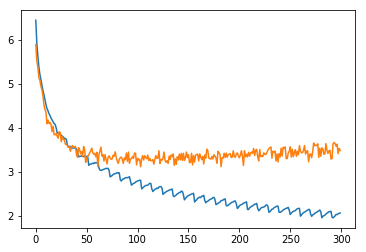

In [13]:
plt.plot(plot_losses_train)
plt.plot(plot_losses_test)
plt.show()

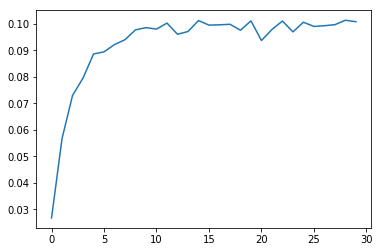

In [14]:
plt.plot(plot_bleu)
plt.show()

In [15]:
plot_bleu

[0.02670205987926194,
 0.056642140992762845,
 0.0729100192686262,
 0.07948229437282239,
 0.08856291028488866,
 0.08937688561597815,
 0.09212480828032818,
 0.09396512232740635,
 0.0976687177408628,
 0.09850319606002476,
 0.09795460554690048,
 0.10023255424089396,
 0.09601608629660334,
 0.09703495083841808,
 0.10117853608179532,
 0.09946302185183578,
 0.09957212510772788,
 0.09977732328217301,
 0.09753998090479221,
 0.10106033401086843,
 0.09364659721985842,
 0.09781284804275464,
 0.10100592489449521,
 0.0969153210019404,
 0.10054531740006743,
 0.09895792507207272,
 0.09922909645186852,
 0.09962742894032316,
 0.10129884539740468,
 0.10074857143517651]